In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import sys
sys.path.append("/Users/mprange/PycharmProjects/flight_phase_seperation/")

import FlightPhaseTools as fpt
from ResearchFlight import ResearchFlight
from ResearchFlightSegment import ResearchFlightSegment

# Load data into xarray datasets using typhon FileSet objects.

In [2]:
bahamas = xr.open_dataset('/Users/mprange/Desktop/halo_unified/unified/bahamas_20200128_v0.4.nc')
dropsondes = xr.open_dataset('/Users/mprange/Desktop/halo_unified/unified/dropsondes_20200128_v0.4.nc')

# Determine the timestamps of the different flight phases using the FlightPhaseTools module.

In [8]:
takeoff = 0
touchdown = len(bahamas['time']) - 1
enter_c1 = fpt.ds_timestamp_ind(bahamas, dropsondes, 0)
exit_c1 = fpt.ds_timestamp_ind(bahamas, dropsondes, 11)
enter_c2 = fpt.ds_timestamp_ind(bahamas, dropsondes, 12)
exit_c2 = fpt.ds_timestamp_ind(bahamas, dropsondes, 23)
enter_c3 = fpt.ds_timestamp_ind(bahamas, dropsondes, 24)
exit_c3 = fpt.ds_timestamp_ind(bahamas, dropsondes, 34)
max_roll_b4_leg1 = fpt.max_timestamp_ind(bahamas, 'roll', 
          slice('2020-01-28T18:30:00', '2020-01-28T19:00:00'),
          order=500
                                        )
enter_leg1 = fpt.find_first_value_after_ts_ind(bahamas, 'roll', max_roll_b4_leg1, 0., 0.05)
max_roll_after_leg1 = fpt.max_timestamp_ind(bahamas, 'roll', 
          slice('2020-01-28T19:00:00', '2020-01-28T19:20:00'),
          order=500
         )
exit_leg1 = fpt.find_first_value_before_ts_ind(bahamas, 'roll', max_roll_after_leg1, 0., 0.05)
min_roll_b4_rad_cal = fpt.min_timestamp_ind(bahamas, 'roll', 
          slice('2020-01-28T19:00:00', '2020-01-28T19:20:00'),
          order=500
         )
enter_rad_cal = fpt.find_first_value_after_ts_ind(bahamas, 'heading', min_roll_b4_rad_cal, 0., 1.0)
max_roll_after_rad_cal = fpt.max_timestamp_ind(bahamas, 'roll', 
          slice('2020-01-28T19:15:00', '2020-01-28T19:30:00'),
          order=500
         )
exit_rad_cal = fpt.find_first_value_before_ts_ind(bahamas, 'roll', max_roll_after_rad_cal, -10., 0.1)
max_roll_b4_leg2 = fpt.max_timestamp_ind(bahamas, 'roll', 
          slice('2020-01-28T19:10:00', '2020-01-28T19:30:00'),
          order=1000
                                   )
enter_leg2 = fpt.find_first_value_after_ts_ind(bahamas, 'roll', max_roll_b4_leg2, 0., 0.05)
max_roll_after_leg2 = fpt.max_timestamp_ind(bahamas, 'roll', 
                                       slice('2020-01-28T19:30:00', '2020-01-28T20:00:00'),
                                       order=1000
                                      )
exit_leg2 = fpt.find_first_value_before_ts_ind(bahamas, 'roll', max_roll_after_leg2, 0., 0.05)
enter_c4 = fpt.ds_timestamp_ind(bahamas, dropsondes, 35)
exit_c4 = fpt.ds_timestamp_ind(bahamas, dropsondes, 45)
enter_c5 = fpt.ds_timestamp_ind(bahamas, dropsondes, 46)
exit_c5 = fpt.ds_timestamp_ind(bahamas, dropsondes, 57)
enter_c6 = fpt.ds_timestamp_ind(bahamas, dropsondes, 58)
exit_c6 = fpt.ds_timestamp_ind(bahamas, dropsondes, 69)
bahamas["altitude_dt"] = (['time'], np.append(np.diff(bahamas["altitude"]),0))
min_dzdt_after_c6 = fpt.min_timestamp_ind(bahamas, 'altitude_dt', 
                      slice('2020-01-28T23:20:00', '2020-01-28T23:40:00'), order=1000)
enter_lidar_cal = fpt.find_first_value_after_ts_ind(bahamas, 'altitude_dt', min_dzdt_after_c6, 0., 0.05)
min_dzdt_after_lidar_cal = fpt.min_timestamp_ind(bahamas, 'altitude_dt', 
                      slice('2020-01-28T23:40:00', '2020-01-28T23:55:00'), order=1000)
exit_lidar_cal = fpt.find_first_value_before_ts_ind(bahamas, 'altitude_dt', min_dzdt_after_lidar_cal, 0., 0.05)




ts_ind_list = [takeoff, touchdown, enter_c1, exit_c1, enter_c2, 
               exit_c2, enter_c3, exit_c3, enter_leg1, 
               exit_leg1, enter_rad_cal, exit_rad_cal, 
               enter_leg2, exit_leg2, enter_c4, exit_c4, 
               enter_c5, exit_c5, enter_c6, exit_c6, enter_lidar_cal,
               exit_lidar_cal,
               ]
label_list = ["takeoff", "touchdown", "enter_c1", "exit_c1", 
              "enter_c2", "exit_c2", "enter_c3", "exit_c3", 
              "enter_leg1", "exit_leg1", "enter_rad_cal", 
              "exit_rad_cal", "enter_leg2", "exit_leg2", 
              "enter_c4", "exit_c4", "enter_c5", "exit_c5", 
              "enter_c6", "exit_c6", "enter_lidar_cal", 
              "exit_lidar_cal"]

# Create basic timeseries of bahamas data with markers for determined timestamps to manually evaluate the validity of the timestamps.

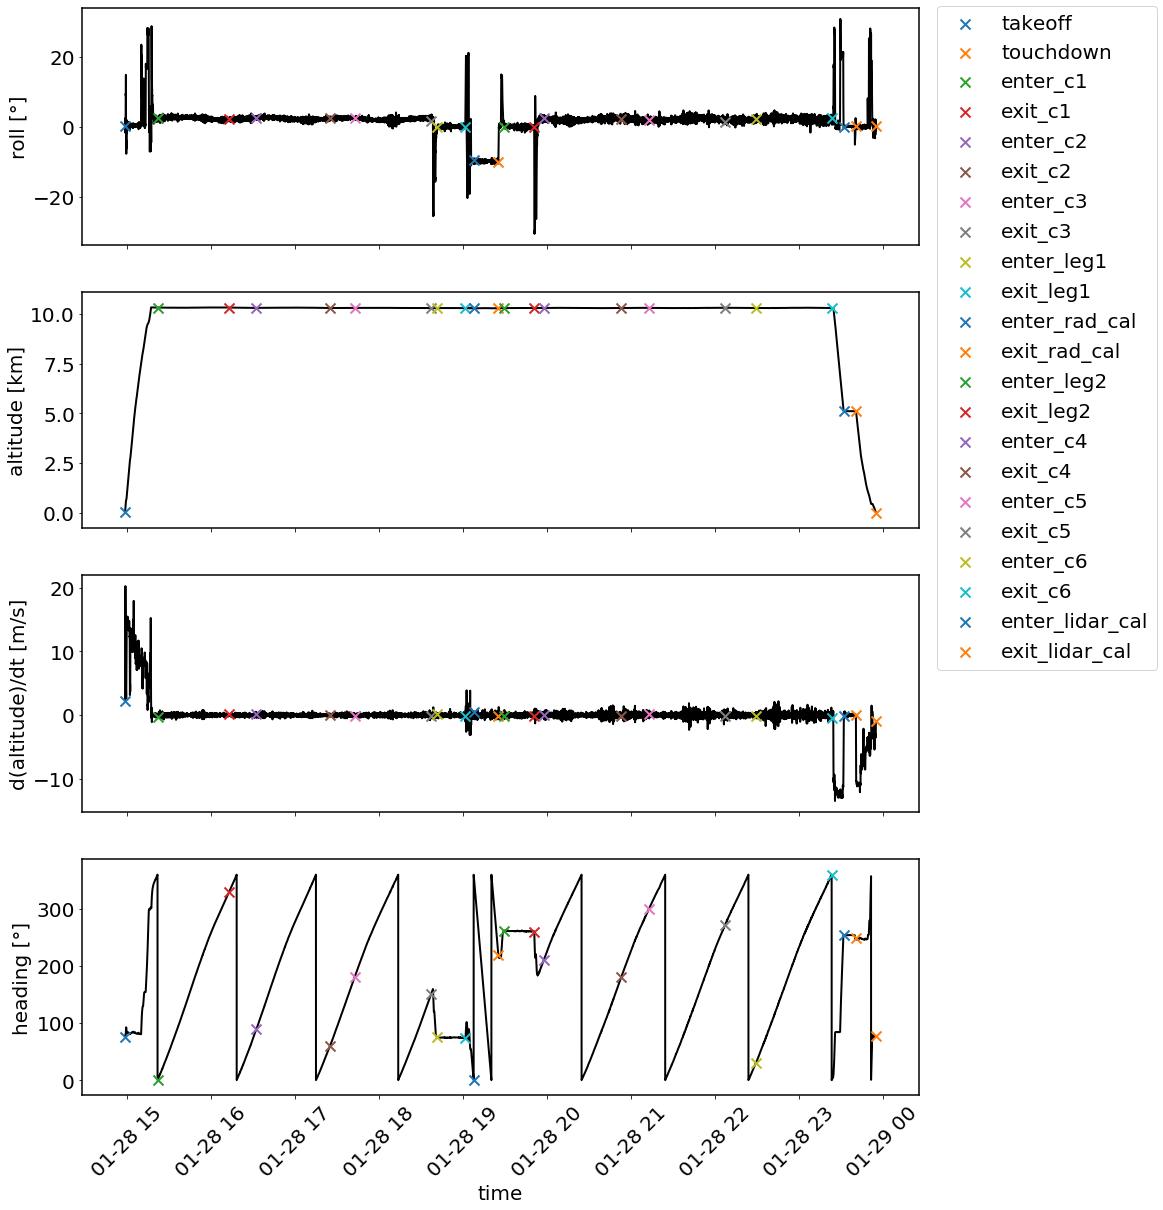

In [9]:
fig, ax = fpt.plot_bahamas_timeseries(bahamas, ts_ind_list, label_list)

# Create xarray datasets of the determined flight phase timestamps and store them as NetCDF files.

## Version 2

In [ ]:
timestamps = fpt.get_unixtime(bahamas['time'][ts_ind_list].values.reshape((int(len(ts_ind_list) / 2), 2)))
flight_phases = np.array(['liftoff_touchdown', 'c1', 'c2', 'c3', 
                              'leg1', 'radar_calibration', 'leg2', 'c4', 'c5', 'c6'])
flight_phase_ds = xr.Dataset(
    {
        "flight_phase": xr.DataArray(flight_phases, dims=("flight_phase",)),
        "start_end": xr.DataArray(["phase_start", "phase_end"], dims=("start_end",)),
        "timestamp": xr.DataArray(timestamps, dims=("flight_phase", "start_end")),
    }, 
    attrs={
        'mission': bahamas.attrs['mission'],
        'flight_number': bahamas.attrs['flight_number'],
        'flight_date': str(pd.to_datetime(bahamas['time'][0].values).date()), 
        'takeoff': str(bahamas['time'][takeoff].values),
        'touchdown': str(bahamas['time'][touchdown].values),
        'contact': 'marc.prange@uni-hamburg.de',
        })
flight_phase_ds

In [ ]:
flight_phase_ds.to_netcdf(
    f'flight_phase_files/RF_{flight_phase_ds.flight_number}_' \
    f'{flight_phase_ds.flight_date}_flight_phase_timestamps_v2.nc')

# Create a ResearchFlight object to represent the flight meta data.

In [17]:
RF05 = ResearchFlight(name=f"RF{bahamas.attrs['flight_number']}",
                      mission=bahamas.attrs['mission'],
                      flight_id='HALO-0128',
                      contacts=[
                          {
                              'name': 'Marc Prange', 
                              'email': 'marc.prange@uni-hamburg.de',
                              'tags': ['dataset creator'],
                          },
                          {
                              'name': 'Bjorn Stevens',
                              'email': 'bjorn.stevens@mpimet.mpg.de',
                              'tags': ['flight PI']
                          }
                      ],
                      date=fpt.dt64_to_dt(bahamas['time'][takeoff].values).date(),
                      takeoff=fpt.dt64_to_dt(bahamas['time'][takeoff].values),
                      landing=fpt.dt64_to_dt(bahamas['time'][touchdown].values),
                      events=[],
                      remarks=['Rather long excursion towards NTAS with radar calibration maneuver.',
                               'Sugar cloud patterns within the circle.'],
)

# Store the flight phase information in ResearchFlightSegment objects.

In [16]:
circle1 = ResearchFlightSegment(kind='circle',
                                name='c1',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c1].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c1].values)
                               )
circle_break1 = ResearchFlightSegment(kind='circle_break',
                                      name='cb1to2',
                                      start=fpt.dt64_to_dt(bahamas["time"][exit_c1].values),
                                      end=fpt.dt64_to_dt(bahamas['time'][enter_c2].values)
                                     )
circle2 = ResearchFlightSegment(kind='circle',
                                name='c2',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c2].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c2].values)
                               )
circle_break2 = ResearchFlightSegment(kind='circle_break',
                                      name='cb2to3',
                                      start=fpt.dt64_to_dt(bahamas["time"][exit_c2].values),
                                      end=fpt.dt64_to_dt(bahamas['time'][enter_c3].values)
                                     )
circle3 = ResearchFlightSegment(kind='circle',
                                name='c3',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c3].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c3].values)
                               )
leg1 = ResearchFlightSegment(kind='straight_leg',
                             name='leg1_towards_NTAS',
                             start=fpt.dt64_to_dt(bahamas["time"][enter_leg1].values),
                             end=fpt.dt64_to_dt(bahamas['time'][exit_leg1].values))
radar_cal = ResearchFlightSegment(kind='radar_calibration_tilted',
                                  name='radar_cal_tilted',
                                  start=fpt.dt64_to_dt(bahamas["time"][enter_rad_cal].values),
                                  end=fpt.dt64_to_dt(bahamas['time'][exit_rad_cal].values)
                                 )
leg2 = ResearchFlightSegment(kind='straight_leg',
                             name='leg2_towards_circle',
                             start=fpt.dt64_to_dt(bahamas["time"][enter_leg2].values),
                             end=fpt.dt64_to_dt(bahamas['time'][exit_leg2].values))
circle4 = ResearchFlightSegment(kind='circle',
                                name='c4',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c4].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c4].values)
                               )
circle_break3 = ResearchFlightSegment(kind='circle_break',
                                      name='cb4to5',
                                      start=fpt.dt64_to_dt(bahamas["time"][exit_c4].values),
                                      end=fpt.dt64_to_dt(bahamas['time'][enter_c5].values)
                                     )
circle5 = ResearchFlightSegment(kind='circle',
                                name='c5',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c5].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c5].values)
                               )
circle_break4 = ResearchFlightSegment(kind='circle_break',
                                      name='cb5to6',
                                      start=fpt.dt64_to_dt(bahamas["time"][exit_c5].values),
                                      end=fpt.dt64_to_dt(bahamas['time'][enter_c6].values)
                                     )
circle6 = ResearchFlightSegment(kind='circle',
                                name='c6',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c6].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c6].values)
                               )
lidar_cal = ResearchFlightSegment(kind='lidar_calibration',
                                  name='lidar_cal',
                                  start=fpt.dt64_to_dt(bahamas["time"][enter_lidar_cal].values),
                                  end=fpt.dt64_to_dt(bahamas['time'][exit_lidar_cal].values)
                                 )

# Append the flight segments to the ResearchFlight object and save the object content to a .yaml file.

In [13]:
RF05.to_dictionary()

{'name': 'RF05',
 'mission': 'EUREC4A',
 'flight_id': 'HALO-0128',
 'contacts': [{'name': 'Marc Prange',
   'email': 'marc.prange@uni-hamburg.de',
   'tags': ['dataset creator']},
  {'name': 'Bjorn Stevens',
   'email': 'bjorn.stevens@mpimet.mpg.de',
   'tags': ['flight PI']}],
 'date': datetime.date(2020, 1, 28),
 'takeoff': datetime.datetime(2020, 1, 28, 14, 58, 34),
 'landing': datetime.datetime(2020, 1, 28, 23, 55, 17),
 'events': [],
 'remarks': ['Rather long excursion towards NTAS with radar calibration maneuver.',
  'sugar cloud patterns within the circle.'],
 'segments': [{'kind': 'circle',
   'name': 'c1',
   'start': datetime.datetime(2020, 1, 28, 15, 21, 54),
   'end': datetime.datetime(2020, 1, 28, 16, 13, 3)},
  {'kind': 'circle',
   'name': 'c2',
   'start': datetime.datetime(2020, 1, 28, 16, 32, 33),
   'end': datetime.datetime(2020, 1, 28, 17, 25, 6)},
  {'kind': 'circle',
   'name': 'c3',
   'start': datetime.datetime(2020, 1, 28, 17, 42, 40),
   'end': datetime.dateti

In [18]:
RF05.append_segments([circle1, circle_break1, circle2, circle_break2, circle3,
                      leg1, radar_cal, leg2, circle4, circle_break3, circle5, circle_break4,
                      circle6, lidar_cal])

In [19]:
RF05.to_yaml(filename='/Users/mprange/PycharmProjects/flight_phase_seperation/flight_phase_files/RF05_info.yaml')